In [1]:
%matplotlib inline

from tqdm import tqdm
from itertools import product
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from numpy.linalg import LinAlgError

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error


import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from freqtrade.configuration import Configuration

In [2]:
sns.set_style('whitegrid')

In [3]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

In [4]:
path='user_data/configs/'

config = Configuration.from_files([path + "config_binance_zone.json"])

data_location = Path(config['user_data_dir'], 'data', 'binance')



In [5]:
config["timeframe"] = '4h'

In [6]:
# Load data using values set above
from freqtrade.data.history import load_pair_history

pairBTC = "BTC_BUSD"

dataFrameBTC = load_pair_history(datadir=data_location,
                            timeframe=config["timeframe"],
                            pair=pairBTC)

pairETH = "ETH_BUSD"
dataFrameETH = load_pair_history(datadir=data_location,
                            timeframe=config["timeframe"],
                            pair=pairETH)
# Confirm success
print("Loaded " + str(len(dataFrameBTC)) + f" rows of data for {pairBTC} from {data_location}")
dataFrameBTC.head()

Loaded 5010 rows of data for BTC_BUSD from /freqtrade/user_data/data/binance


,date,open,high,low,close,volume
0,2019-09-19 08:00:00+00:00,9881.43,9881.43,9828.59,9849.75,0.056889
1,2019-09-19 12:00:00+00:00,9848.41,9887.21,9848.41,9866.53,0.033663
2,2019-09-19 16:00:00+00:00,9875.25,10082.81,9875.25,10082.81,0.489274
3,2019-09-19 20:00:00+00:00,10082.81,10305.58,10082.81,10254.92,0.471222
4,2019-09-20 00:00:00+00:00,10214.31,10214.52,10214.31,10214.52,0.005046


In [7]:
# dataFrame['close']

btcbusd = dataFrameBTC.set_index('date', drop=False).drop(columns = ['date', 'open', 'high', 'low','volume'])
ethbusd = dataFrameETH.set_index('date', drop=False).drop(columns = ['date', 'open', 'high', 'low','volume'])
btcbusd

,close
date,
2019-09-19 08:00:00+00:00,9849.75
2019-09-19 12:00:00+00:00,9866.53
2019-09-19 16:00:00+00:00,10082.81
2019-09-19 20:00:00+00:00,10254.92
2019-09-20 00:00:00+00:00,10214.52
...,...
2021-12-31 12:00:00+00:00,47995.33
2021-12-31 16:00:00+00:00,45725.92
2021-12-31 20:00:00+00:00,46208.25


In [8]:
btccomponents = tsa.seasonal_decompose(btcbusd, model='additive')
ethcomponents = tsa.seasonal_decompose(ethbusd, model='additive')

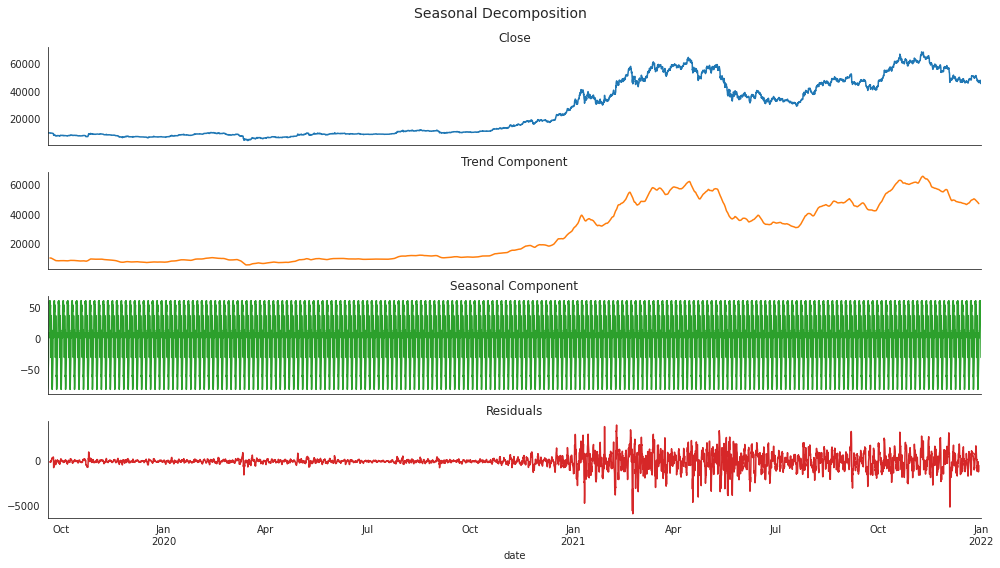

In [9]:
tsBTC = (btcbusd
      .assign(Trend=btccomponents.trend)
      .assign(Seasonality=btccomponents.seasonal)
      .assign(Residual=btccomponents.resid))
with sns.axes_style('white'):
    tsBTC.plot(subplots=True, figsize=(14, 8), title=['Close', 'Trend Component', 'Seasonal Component','Residuals'], legend=False)
    plt.suptitle('Seasonal Decomposition', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91);

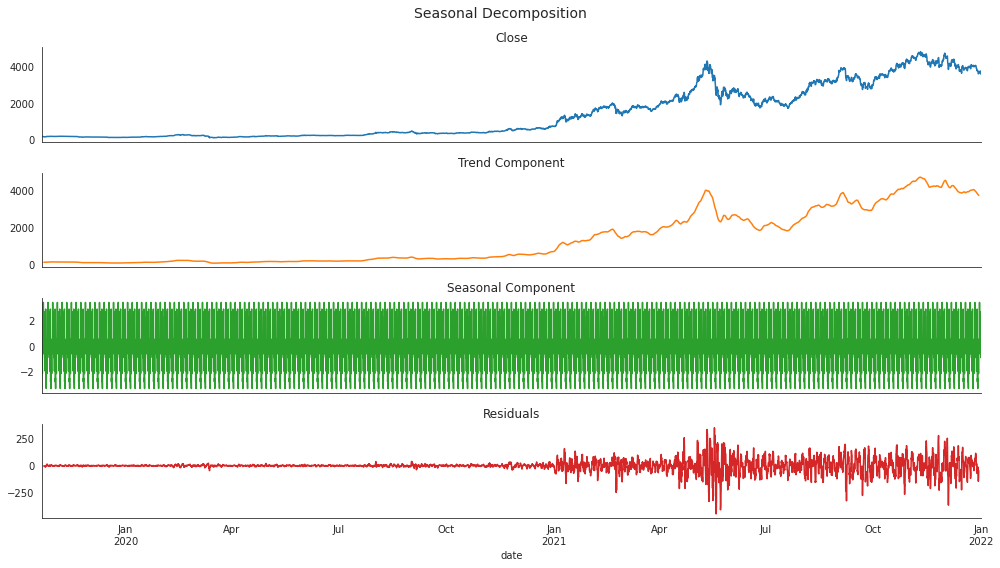

In [10]:
tsETH = (ethbusd
      .assign(Trend=ethcomponents.trend)
      .assign(Seasonality=ethcomponents.seasonal)
      .assign(Residual=ethcomponents.resid))
with sns.axes_style('white'):
    tsETH.plot(subplots=True, figsize=(14, 8), title=['Close', 'Trend Component', 'Seasonal Component','Residuals'], legend=False)
    plt.suptitle('Seasonal Decomposition', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91);

## Time Series Stationarity

In [11]:
(btcbusd == 0).any(), (ethbusd==0).any()

(close    False
 dtype: bool,
 close    False
 dtype: bool)

In [12]:
btcbusd_log = np.log(btcbusd)
btcbusd_log_diff = btcbusd_log.diff().dropna()

ethbusd_log = np.log(ethbusd)
ethbusd_log_diff = ethbusd_log.diff().dropna()

In [13]:
btcbusd_log_diff = btcbusd_log.diff().dropna()

# seasonal differencing => yoy instantanteous returns
ethbusd_log_diff = ethbusd_log.diff(12).dropna()

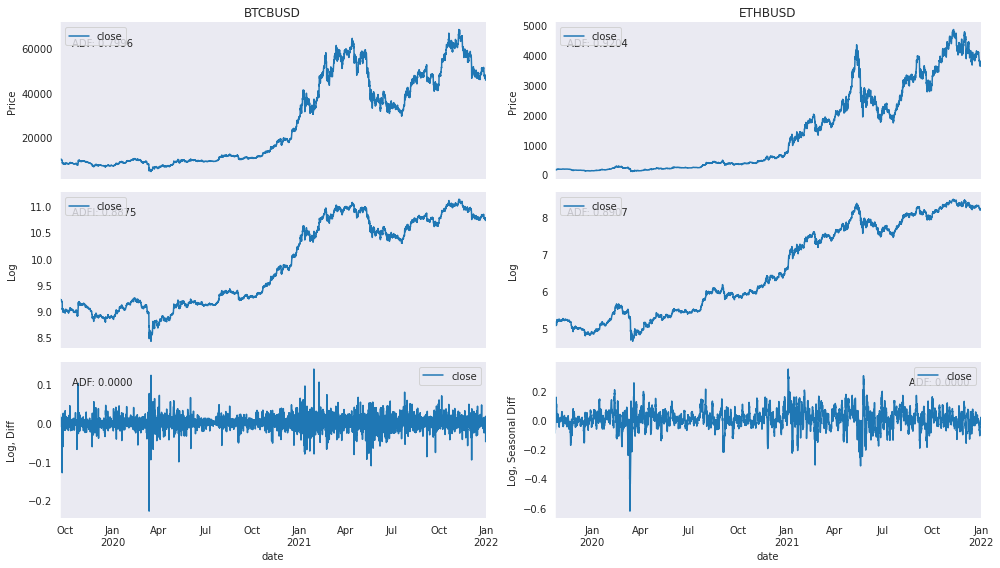

In [14]:
with sns.axes_style('dark'):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 8))

    btcbusd.plot(ax=axes[0][0],
                title='BTCBUSD')
    axes[0][0].text(x=.03,
                    y=.85,
                    s=f'ADF: {tsa.adfuller(btcbusd.dropna())[1]:.4f}',
                    transform=axes[0][0].transAxes)
    axes[0][0].set_ylabel('Price')

    btcbusd_log.plot(ax=axes[1][0],
                    sharex=axes[0][0])
    axes[1][0].text(x=.03, y=.85,
                    s=f'ADFl: {tsa.adfuller(btcbusd_log.dropna())[1]:.4f}',
                    transform=axes[1][0].transAxes)
    axes[1][0].set_ylabel('Log')

    btcbusd_log_diff.plot(ax=axes[2][0],
                         sharex=axes[0][0])
    axes[2][0].text(x=.03, y=.85,
                    s=f'ADF: {tsa.adfuller(btcbusd_log_diff.dropna())[1]:.4f}',
                    transform=axes[2][0].transAxes)
    axes[2][0].set_ylabel('Log, Diff')

    ethbusd.plot(ax=axes[0][1],
                               title='ETHBUSD')
    axes[0][1].text(x=.03, y=.85,
                    s=f'ADF: {tsa.adfuller(ethbusd)[1]:.4f}',
                    transform=axes[0][1].transAxes)
    axes[0][1].set_ylabel('Price')

    ethbusd_log.plot(ax=axes[1][1],
                                   sharex=axes[0][1])
    axes[1][1].text(x=.03, y=.85,
                    s=f'ADF: {tsa.adfuller(ethbusd_log.dropna())[1]:.4f}',
                    transform=axes[1][1].transAxes)
    axes[1][1].set_ylabel('Log')

    ethbusd_log_diff.plot(ax=axes[2][1],
                                        sharex=axes[0][1])
    axes[2][1].text(x=.83, y=.85,
                    s=f'ADF: {tsa.adfuller(ethbusd_log_diff.dropna())[1]:.4f}',
                    transform=axes[2][1].transAxes)
    axes[2][1].set_ylabel('Log, Seasonal Diff')
    sns.despine()
    fig.tight_layout()
    fig.align_ylabels(axes)

## Correlogram

In [15]:
btcbusd_log_diff

,close
date,
2019-09-19 12:00:00+00:00,0.001702
2019-09-19 16:00:00+00:00,0.021684
2019-09-19 20:00:00+00:00,0.016926
2019-09-20 00:00:00+00:00,-0.003947
2019-09-20 04:00:00+00:00,-0.004928
...,...
2021-12-31 12:00:00+00:00,0.000191
2021-12-31 16:00:00+00:00,-0.048438
2021-12-31 20:00:00+00:00,0.010493


/home/ftuser/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


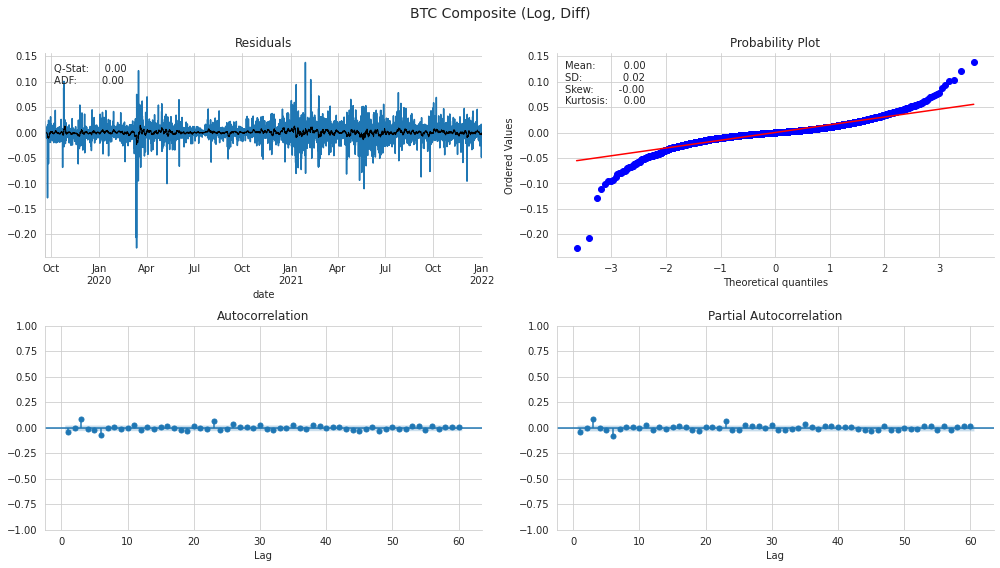

In [16]:
plot_correlogram(btcbusd_log_diff.squeeze(), lags=60, title='BTC Composite (Log, Diff)')

/home/ftuser/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


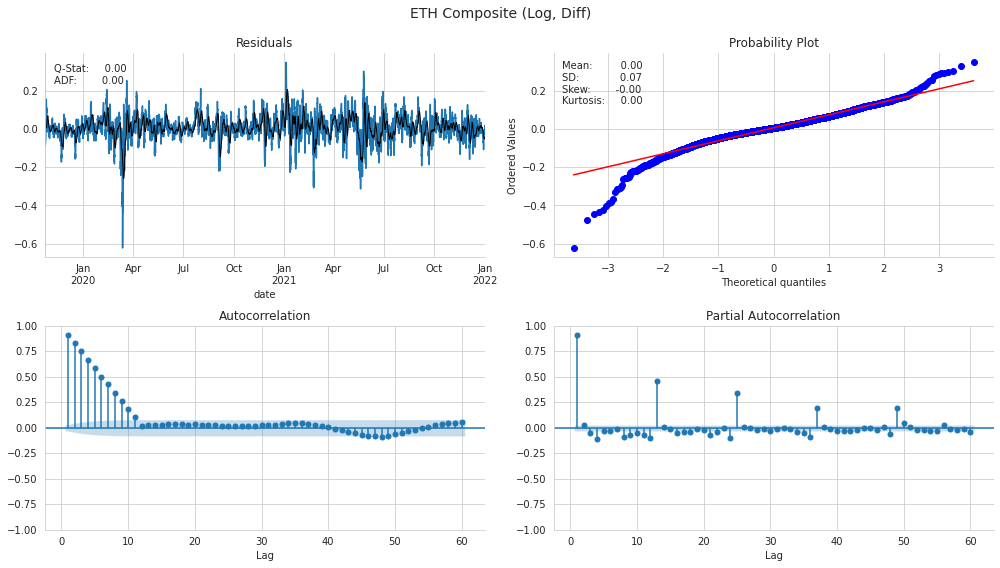

In [17]:
plot_correlogram(ethbusd_log_diff.squeeze(), lags=60, title='ETH Composite (Log, Diff)')

In [18]:
model1 = tsa.ARIMA(endog=btcbusd_log_diff, order=(2,0,2)).fit() # ARMA = ARIMA  
model2 = tsa.ARIMA(endog=btcbusd_log, order=(2,1,2)).fit()

model2

/home/ftuser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  warnings.warn('No frequency information was'
/home/ftuser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  warnings.warn('No frequency information was'
/home/ftuser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  warnings.warn('No frequency information was'
/home/ftuser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  warnings.warn('No frequency information was'
/home/ftuser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:536: Valu

In [19]:
model1.params

const     0.000311
ar.L1    -0.165864
ar.L2    -0.570451
ma.L1     0.103865
ma.L2     0.543584
sigma2    0.000268
dtype: float64

In [20]:
model2.params

ar.L1    -0.154936
ar.L2    -0.566044
ma.L1     0.092245
ma.L2     0.540870
sigma2    0.000268
dtype: float64

In [21]:
model1 = tsa.statespace.SARIMAX(ethbusd_log, order=(2,0,2), seasonal_order=(0,1,0,12)).fit()
model2 = tsa.statespace.SARIMAX(ethbusd_log_diff, order=(2,0,2), seasonal_order=(0,0,0,12)).fit()

/home/ftuser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  warnings.warn('No frequency information was'
/home/ftuser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.12813D+00    |proj g|=  1.21949D-01

At iterate    5    f= -2.12865D+00    |proj g|=  9.07397D-01

At iterate   10    f= -2.12906D+00    |proj g|=  7.43438D-03

At iterate   15    f= -2.12978D+00    |proj g|=  9.83780D-02

At iterate   20    f= -2.12988D+00    |proj g|=  4.71185D-03

At iterate   25    f= -2.12992D+00    |proj g|=  2.19329D-02

At iterate   30    f= -2.13145D+00    |proj g|=  6.31701D-01

At iterate   35    f= -2.13190D+00    |proj g|=  5.89247D-03

At iterate   40    f= -2.13191D+00    |proj g|=  1.62470D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/home/ftuser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  warnings.warn('No frequency information was'
/home/ftuser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.13345D+00    |proj g|=  1.22231D-01

At iterate    5    f= -2.13404D+00    |proj g|=  9.12603D-01

At iterate   10    f= -2.13438D+00    |proj g|=  7.06262D-03

At iterate   15    f= -2.13508D+00    |proj g|=  2.35627D-02

At iterate   20    f= -2.13517D+00    |proj g|=  6.83031D-02

At iterate   25    f= -2.13520D+00    |proj g|=  4.82083D-02

At iterate   30    f= -2.13539D+00    |proj g|=  7.92867D-01

At iterate   35    f= -2.13717D+00    |proj g|=  1.12684D-02

At iterate   40    f= -2.13724D+00    |proj g|=  2.81246D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

In [22]:
model1.params.to_frame('SARIMAX').join(model2.params.to_frame('diff'))


,SARIMAX,diff
ar.L1,1.767242,1.767262
ar.L2,-0.793766,-0.793571
ma.L1,-0.896919,-0.896714
ma.L2,0.116692,0.116082
sigma2,0.000814,0.000814


In [23]:
btcbusd_log_diff.squeeze()

date
2019-09-19 12:00:00+00:00    0.001702
2019-09-19 16:00:00+00:00    0.021684
2019-09-19 20:00:00+00:00    0.016926
2019-09-20 00:00:00+00:00   -0.003947
2019-09-20 04:00:00+00:00   -0.004928
                               ...   
2021-12-31 12:00:00+00:00    0.000191
2021-12-31 16:00:00+00:00   -0.048438
2021-12-31 20:00:00+00:00    0.010493
2022-01-01 00:00:00+00:00    0.013011
2022-01-01 04:00:00+00:00    0.008271
Name: close, Length: 5009, dtype: float64

In [25]:
btca = btcbusd_log_diff.squeeze()
print(len(btca))
train_size = 50

print(range(train_size, len(btca)))
T = 51
train_set = btca.iloc[T-train_size:T]
train_set.index = pd.DatetimeIndex(train_set.index.values,
                               freq=train_set.index.inferred_freq)
model = tsa.ARIMA(endog=train_set, order=(0,0,1)).fit()



model.forecast(steps=1)

5009
range(50, 5009)


2019-09-28   -0.00678
Freq: 4H, dtype: float64

## Explore Returns and Volatility

In [27]:
btcbusd.head()

,close
date,
2019-09-19 08:00:00+00:00,9849.75
2019-09-19 12:00:00+00:00,9866.53
2019-09-19 16:00:00+00:00,10082.81
2019-09-19 20:00:00+00:00,10254.92
2019-09-20 00:00:00+00:00,10214.52


/home/ftuser/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


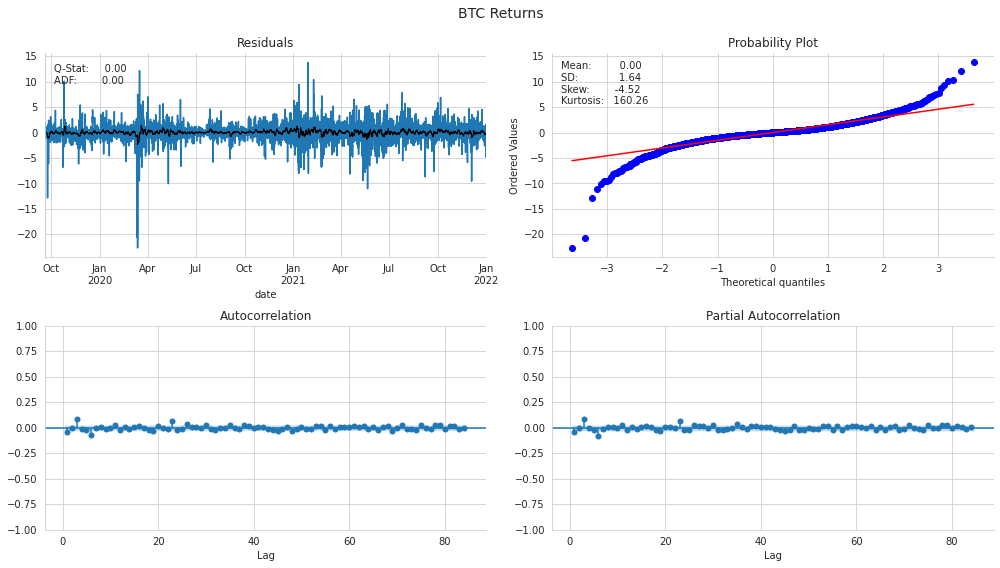

In [33]:
btcbusd_returns = np.log(btcbusd).diff().dropna().mul(100)
plot_correlogram(btcbusd_returns.squeeze(), lags=84, title='BTC Returns')

/home/ftuser/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


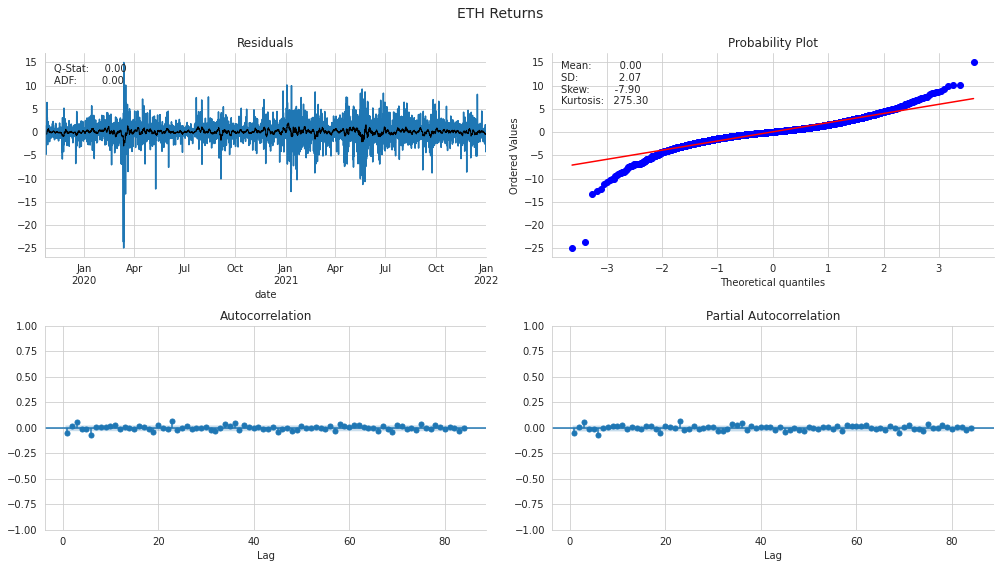

In [34]:
ethbusd_returns = np.log(ethbusd).diff().dropna().mul(100)
plot_correlogram(ethbusd_returns.squeeze(), lags=84, title='ETH Returns')

/home/ftuser/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


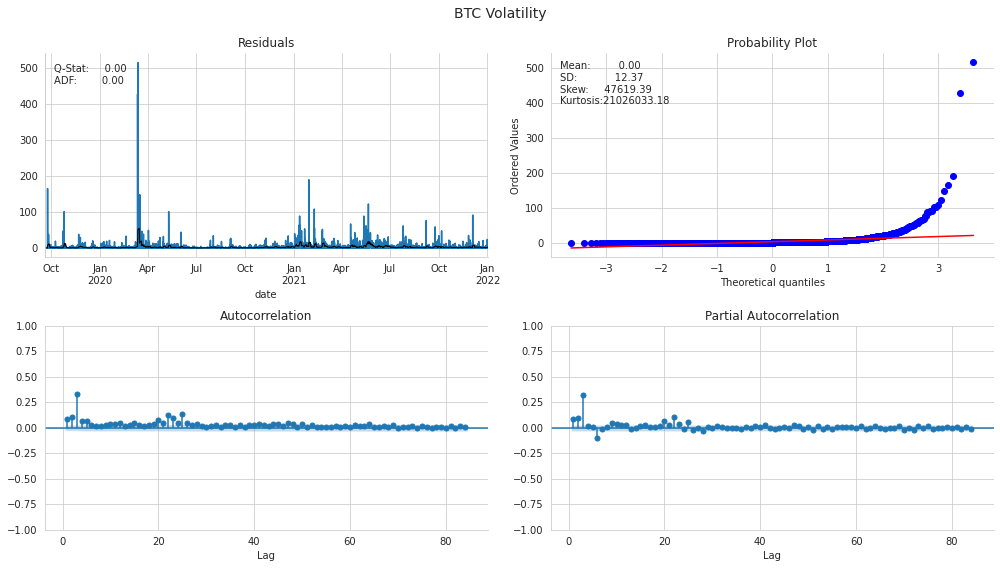

In [46]:
btcbusd_returns = btcbusd_returns.squeeze()
plot_correlogram(btcbusd_returns.sub(btcbusd_returns.mean()).pow(2), lags=84, title='BTC Volatility')

/home/ftuser/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


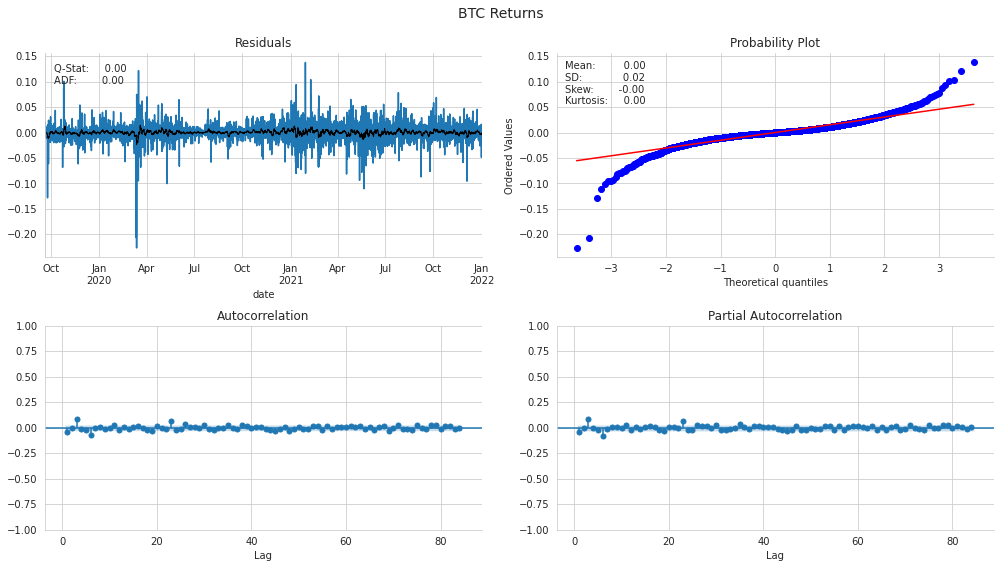

In [49]:
btcbusd_percent = np.log(btcbusd).diff().dropna().squeeze()
plot_correlogram(btcbusd_percent, lags=84, title='BTC Returns')

## Estimate GARCH(2, 2) Model

In [42]:
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal

best_p, best_q = 2, 2,

In [43]:
am = ConstantMean(btcbusd_returns.clip(lower=btcbusd_returns.quantile(.05),
                                      upper=btcbusd_returns.quantile(.95)))
am.volatility = GARCH(best_p, 0, best_q)
am.distribution = Normal()
best_model = am.fit(update_freq=5)
print(best_model.summary())

Iteration:      5,   Func. Count:     47,   Neg. LLF: 17701.953653818095
Iteration:     10,   Func. Count:     87,   Neg. LLF: 7569.04607957862
Iteration:     15,   Func. Count:    127,   Neg. LLF: 7562.768137360716
Iteration:     20,   Func. Count:    163,   Neg. LLF: 7561.135136274496
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7561.135136275836
            Iterations: 20
            Function evaluations: 163
            Gradient evaluations: 20
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7561.14
Distribution:                  Normal   AIC:                           15134.3
Method:            Maximum Likelihood   BIC:                           15173.4
                            

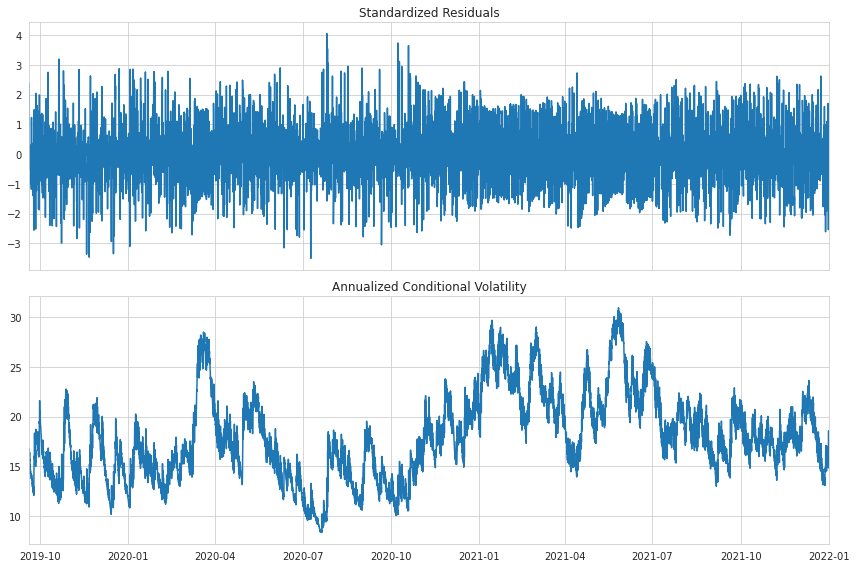

In [44]:
fig = best_model.plot(annualize='D')
fig.set_size_inches(12, 8)
fig.tight_layout();

GARCH(p: 2, q: 2), id: 0x7f66c709c3a0

/home/ftuser/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


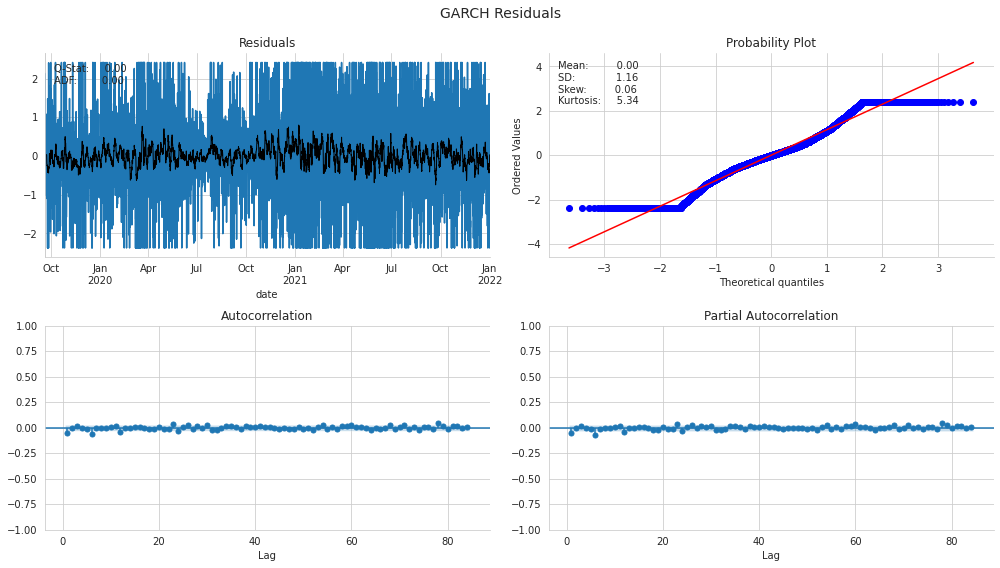

In [47]:
plot_correlogram(best_model.resid.dropna(),
                 lags=84,
                 title='GARCH Residuals')

### Unit Root Test

In [48]:
def test_unit_root(df):
    return df.apply(lambda x: f'{pd.Series(adfuller(x)).iloc[1]:.2%}').to_frame('p-value')

## Finding the optimal ARMA lags

In [ ]:
train_size = 50
results = {}
y_true = btcbusd_log_diff.iloc[train_size:]
for p in range(5):
    for q in range(5):
        aic, bic = [], []
        if p == 0 and q == 0:
            continue
        print(p, q)
        convergence_error = stationarity_error = 0
        y_pred = []
        for T in range(train_size, len(btcbusd_log_diff)):
            train_set = btcbusd_log_diff.iloc[T-train_size:T]
            try:
                model = tsa.ARIMA(endog=train_set, order=(p,0,q)).fit()
            except LinAlgError:
                convergence_error += 1
            except ValueError:
                stationarity_error += 1

            forecast, _, _ = model.forecast(steps=1)
            y_pred.append(forecast[0])
            aic.append(model.aic)
            bic.append(model.bic)

        result = (pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
                  .replace(np.inf, np.nan)
                  .dropna())

        rmse = np.sqrt(mean_squared_error(
            y_true=result.y_true, y_pred=result.y_pred))

        results[(p, q)] = [rmse,
                           np.mean(aic),
                           np.mean(bic),
                           convergence_error,
                           stationarity_error]

0 1


/home/ftuser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  warnings.warn('No frequency information was'
/home/ftuser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  warnings.warn('No frequency information was'
/home/ftuser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  warnings.warn('No frequency information was'


ValueError: not enough values to unpack (expected 3, got 1)